In [1]:
import himalaya.scoring
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend, get_backend
from himalaya.ridge import RidgeCV, GroupRidgeCV

from simulation import generate_dataset

In [2]:
set_backend('cupy', on_error='warn')
backend = get_backend()
plt.style.use('nord')
sns.set_theme(style='whitegrid')

/home/leo/git/compare_variance_residual/venv/lib/python3.12/site-packages/himalaya/backend/_utils.py:55: UserWarning: Setting backend to cupy failed: Cupy not installed..Falling back to numpy backend.
  warnings.warn(f"Setting backend to {backend} failed: {str(error)}."


In [3]:
d_list = [100, 100, 100]
scalars = [1 / 3, 1 / 3, 1 / 3]
n_targets = 10000
n_samples_train = 10000
n_samples_test = 100
n_samples = n_samples_train + n_samples_test
noise_scalar = 0.1

In [4]:
alphas = np.logspace(-4, 4, 10)
cv = 10
score_func = himalaya.scoring.r2_score

In [5]:
Xs, Y = generate_dataset(d_list, scalars, n_targets, n_samples, noise_scalar, construction_method="random")

train joint model

In [6]:
banded_solver_params = dict(n_iter=10, alphas=alphas, warn=False, score_func=score_func, n_targets_batch=1000)
joint_model = GroupRidgeCV(groups="input", solver_params=banded_solver_params)

In [7]:
joint_model.fit([x[:n_samples_train] for x in Xs], Y[:n_samples_train])
joint_score = joint_model.score([x[n_samples_train:] for x in Xs], Y[n_samples_train:])
joint_score = backend.to_numpy(joint_score)

[........................................] 100% | 1276.72 sec | 10 random sampling with cv | 


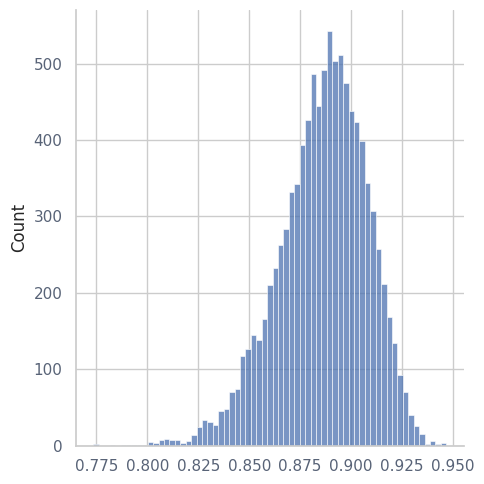

In [8]:
sns.displot(joint_score)

train single models

In [9]:
solver_params = dict(warn=False, score_func=score_func, n_targets_batch=1000)
single_model = RidgeCV(alphas=alphas, cv=cv, solver_params=solver_params)
single_model.fit(Xs[0][:n_samples_train], Y[:n_samples_train])
score_0 = single_model.score(Xs[0][n_samples_train:], Y[n_samples_train:])
score_0 = backend.to_numpy(score_0)

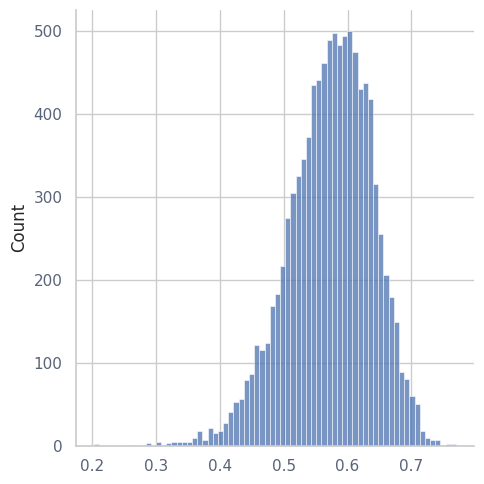

In [10]:
sns.displot(score_0)

In [11]:
solver_params = dict(warn=False, score_func=score_func, n_targets_batch=1000)
single_model = RidgeCV(alphas=alphas, cv=cv, solver_params=solver_params)
single_model.fit(Xs[1][:n_samples_train], Y[:n_samples_train])
score_1 = single_model.score(Xs[1][n_samples_train:], Y[n_samples_train:])
score_1 = backend.to_numpy(score_1)

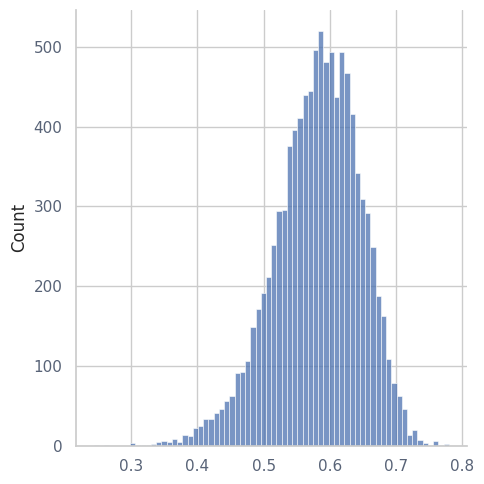

In [12]:
sns.displot(score_1)

Calculate unique and shared variance

In [13]:
shared = (score_0 + score_1) - joint_score
x0_unique = score_0 - shared
x1_unique = score_1 - shared

In [14]:
shared = backend.to_numpy(shared)
x0_unique = backend.to_numpy(x0_unique)
x1_unique = backend.to_numpy(x1_unique)

create pandas dataset of all scores for analysis

In [20]:
scores = pd.DataFrame()
scores[r"$[X_1, X_2]b = y$"] = joint_score
scores[r"$X_1b = y$"] = score_0
scores[r"$X_2b = y$"] = score_1
scores[r"$R^2(X_1b = y)\cap R^2(X_2b = y)$"] = shared
scores[r"$R^2(X_1b=y) \setminus R^2(X_2b=y)$"] = x0_unique
scores[r"$R^2(X_2b=y) \setminus R^2(X_1b=y)$"] = x1_unique
scores.head()

,"$[X_1, X_2]b = y$",$X_1b = y$,$X_2b = y$,$R^2(X_1b = y)\cap R^2(X_2b = y)$,$R^2(X_1b=y) \setminus R^2(X_2b=y)$,$R^2(X_2b=y) \setminus R^2(X_1b=y)$
0,0.873151,0.521549,0.510359,0.158757,0.362792,0.351602
1,0.878681,0.644168,0.614201,0.379687,0.264481,0.234514
2,0.916057,0.564514,0.638177,0.286634,0.277880,0.351543
3,0.926171,0.662948,0.590600,0.327377,0.335571,0.263224
4,0.877988,0.546705,0.535944,0.204662,0.342044,0.331282


Text(0.0, 1.0, 'Variance Partitioning')

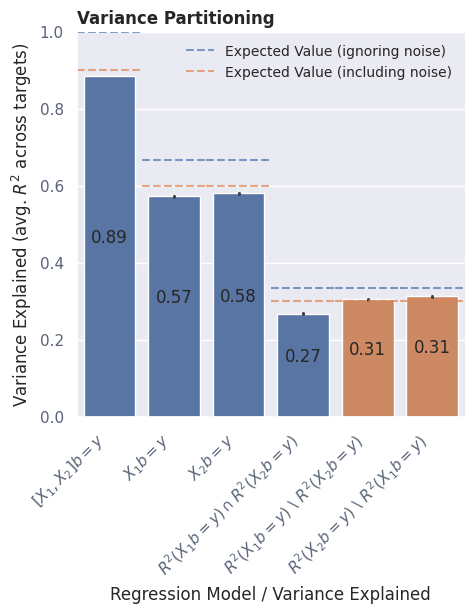

In [30]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.barplot(
    data=scores,
    palette=["C0", "C0", "C0", "C0", "C1", "C1"],  # Define colors: one for joint/X₁/X₂, one for unique/shared
    ax=ax,

)
sns.despine(fig)
theoretical_scores = [sum(scalars), scalars[0] + scalars[1], scalars[0] + scalars[2], scalars[0], scalars[1],
                      scalars[2]]
theoretical_scores_nosise = [score * (1 - noise_scalar) for score in theoretical_scores]

# Add lines indicating the maximum possible height for each bar
for idx, column in enumerate(scores.columns):  # iterate over rows in the DataFrame
    xmin = idx / len(scores.columns)  # Calculate xmin for each bar
    xmax = (idx + 1) / len(scores.columns)  # Calculate xmax for each bar
    plt.axhline(theoretical_scores[idx], linestyle='--', alpha=0.7, color='C0',
                xmin=xmin, xmax=xmax, label=fr'Expected Value (ignoring noise)' if idx == 0 else "")
    plt.axhline(theoretical_scores_nosise[idx], linestyle='--', alpha=0.7, color='C1',
                xmin=xmin, xmax=xmax, label=fr'Expected Value (including noise)' if idx == 0 else "")

    plt.text(idx, scores[column].mean() / 2,
             f"{scores[column].mean():.2f}", ha='center', va='bottom')

plt.xticks(range(len(scores.columns)), scores.columns, rotation=45, ha='right')

plt.ylim(0, 1)

# Ensure the legend is displayed properly
plt.legend(fontsize=10)
plt.ylabel(r"Variance Explained (avg. $R^2$ across targets)")
plt.xlabel(r"Regression Model / Variance Explained")
plt.title("Variance Partitioning")